In [1]:
import os
import re
from glob import glob
from importlib import reload

from collections import OrderedDict

import numpy as np

from astropy import units as u
from astropy import coordinates
from astropy.coordinates import SkyCoord, UnitSphericalRepresentation
from astropy import table
from astropy.visualization import hist as ahist

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# a fun trick that makes the notebook always be 95% of the browser window
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

# First parse/load the data 

In [4]:
import data_loaders

In [5]:
elvii_pairs = data_loaders.load_elvii(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/Burr&Hamilton.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Charybdis&Scylla.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Cher&Sonny.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Kauket&Kek.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Taurus&Orion.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Venus&Serana.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Zeus&Hera.txt


In [6]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

In [7]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


# Now some LG-simulating behavior

First we produce $M_{HI}$ for everything following Bradford+15

In [8]:
def bradford_15_mstar_to_mgas(mstar):
    logx = np.log10(mstar/u.Msun)
    faintmsk = logx < 8.6
    mgas = np.empty_like(logx)
    mgas[faintmsk] = 1.052 *logx[faintmsk] + 0.236
    mgas[~faintmsk] = 0.461 *logx[~faintmsk] + 5.329
    return u.solMass*10**mgas

In [9]:
# produce HI masses for each table
for tab in elvii_pairs.values():
    Ms = tab['Mstar_preferred']
    tab['MHI'] = bradford_15_mstar_to_mgas(Ms)

Now we populate the tables with coordinates for an artificial "LG"

In [10]:
for tab in elvii_pairs.values():
    #these add host{n}_lat/host{n}_lon/host{n}_dist
    data_loaders.add_oriented_radecs(tab, 0, 1, target_coord=m31)
    data_loaders.add_oriented_radecs(tab, 1, 0, target_coord=m31)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


Now we pull the sensitivity from the GALFA image

In [11]:
for tab in elvii_pairs.values():
    for i in (0, 1):
        host_sc = SkyCoord(ra=tab['host{}_lon'.format(i)], 
                           dec=tab['host{}_lat'.format(i)])
        
        pxs = host_sc.to_pixel(galfa_sens_wcs)
        xp = np.round(pxs[0]).astype(int)
        yp = np.round(pxs[1]).astype(int)
        msk = (0<=xp)&(xp<galfa_sens.shape[0])&(0<=yp)&(yp<galfa_sens.shape[1])
        
        sens = np.zeros(len(tab), dtype=galfa_sens.dtype)*galfa_sens.unit
        sens[msk] = galfa_sens[xp[msk], yp[msk]]
        sens[sens==0] = np.inf
        
        tab['closest_sens{}'.format(i)] = sens

And then compute if the line is detectable

In [ ]:
for name, tab in elvii_pairs.items():
    MHI = tab['MHI']
    for i in (0, 1):
        sens = tab['closest_sens{}'.format(i)]
        det = sens*tab['host{}_dist'.format(i)]**2 < MHI
        tab['detectable{}'.format(i)] = det

### Velocity histograms 

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


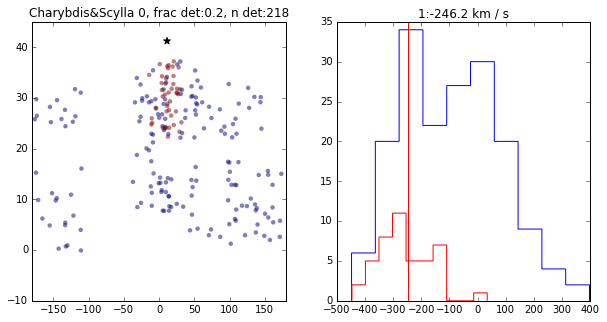

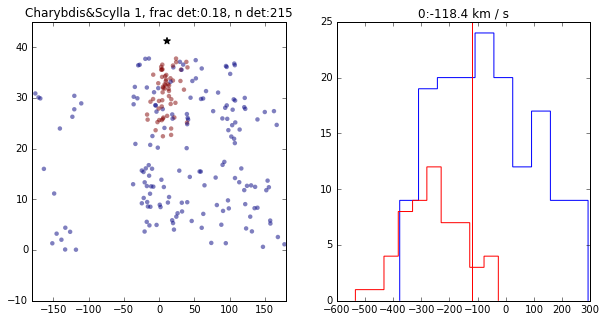

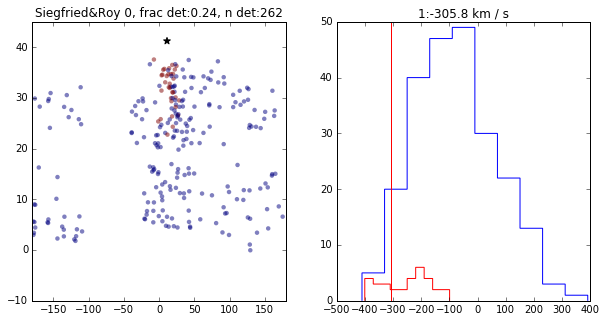

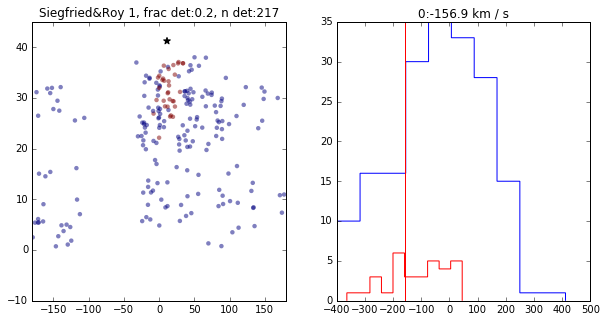

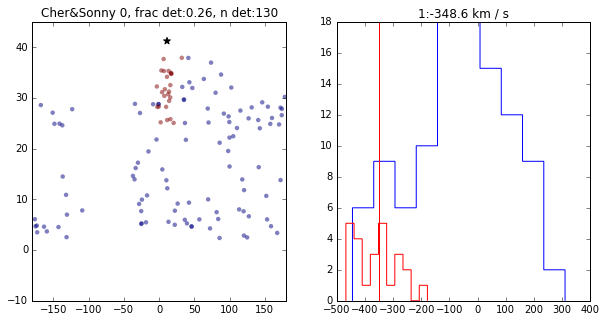

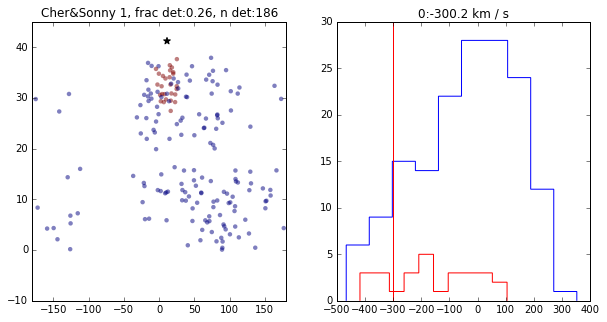

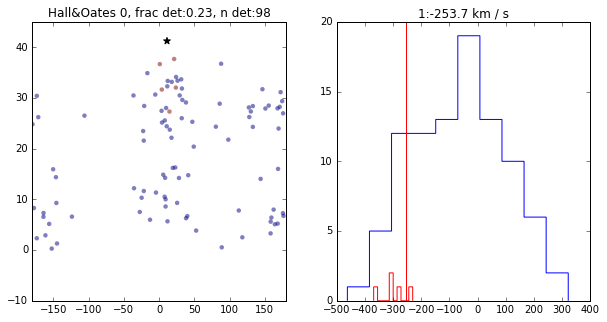

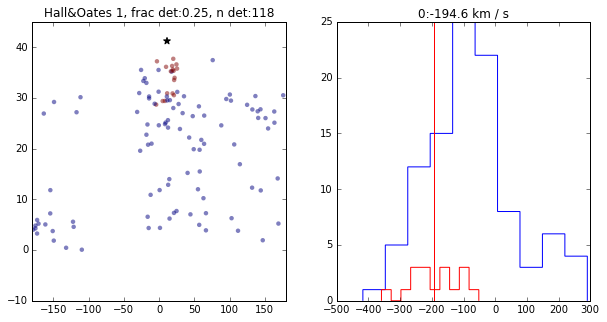

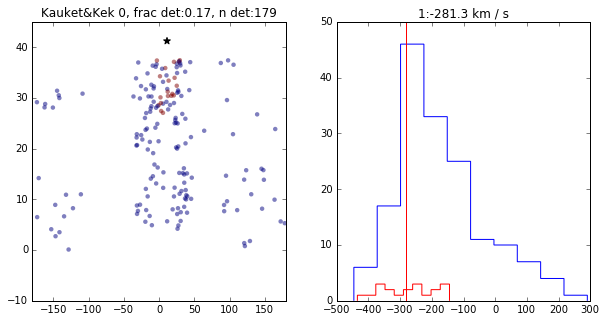

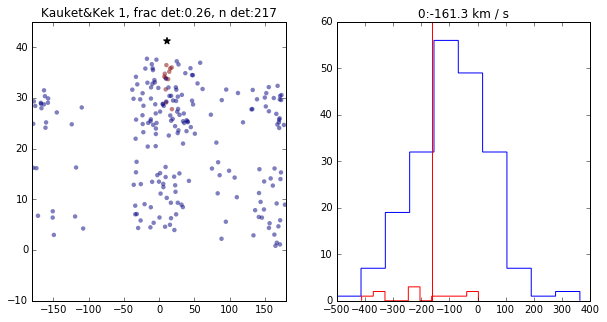

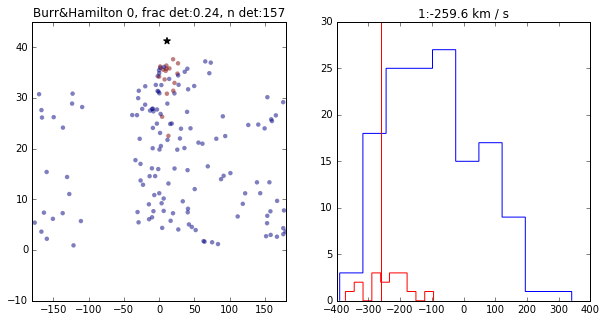

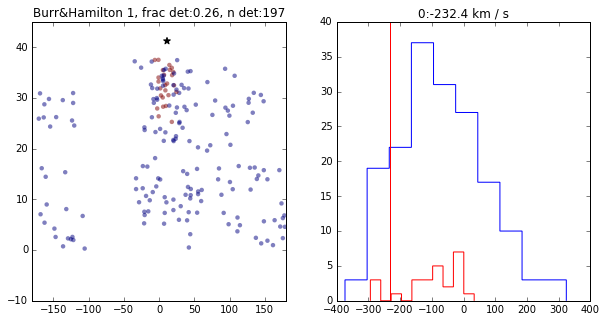

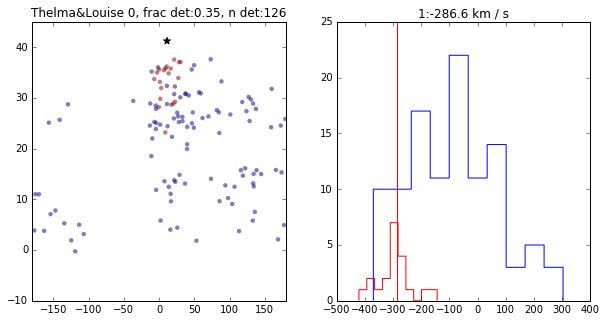

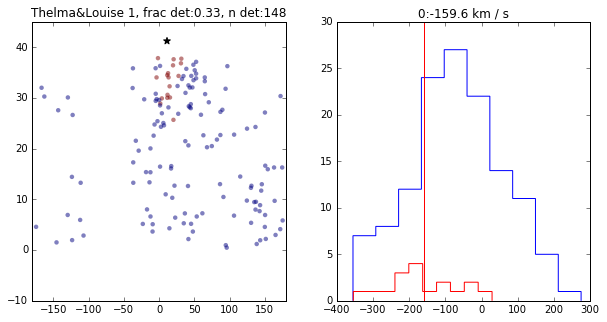

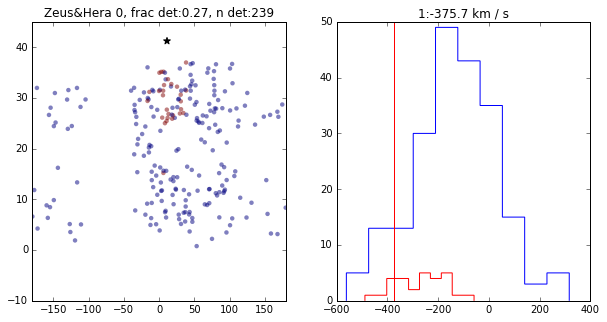

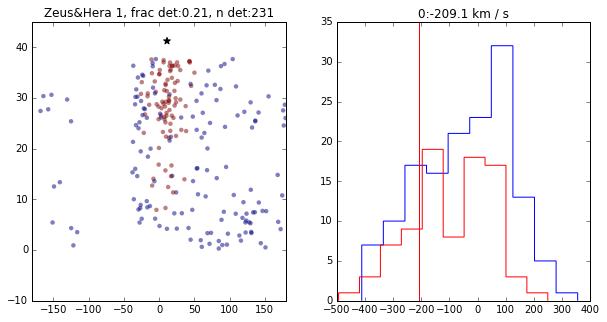

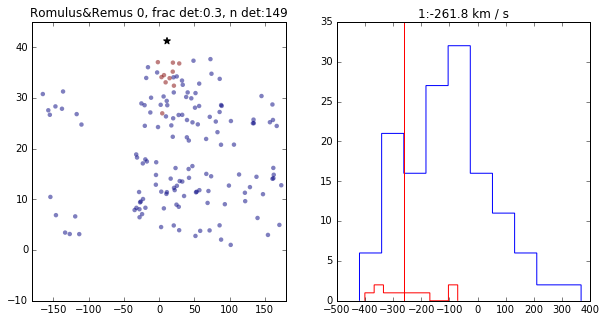

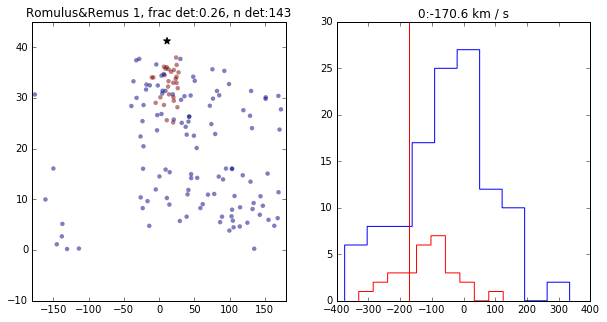

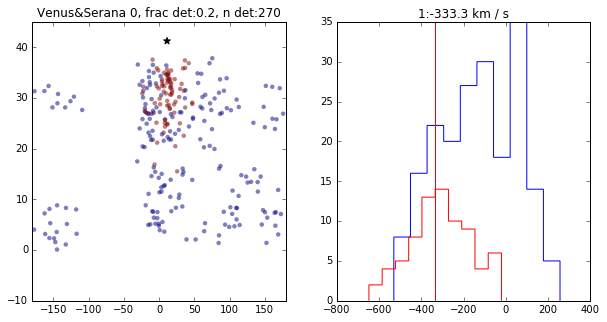

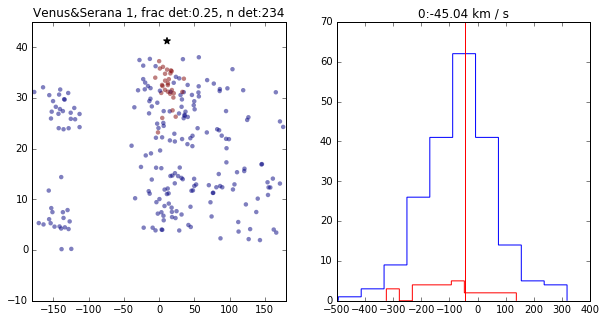

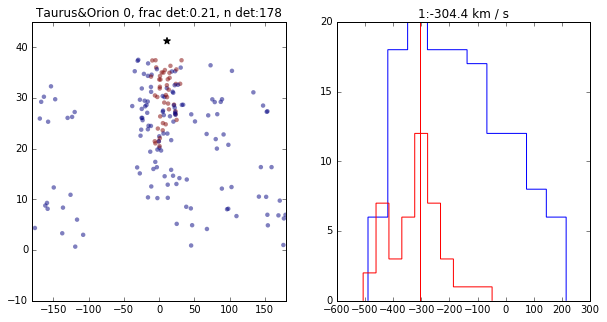

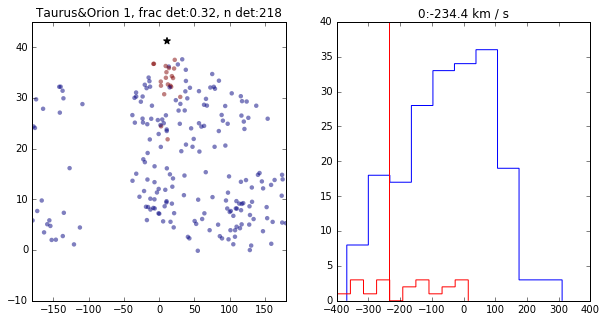

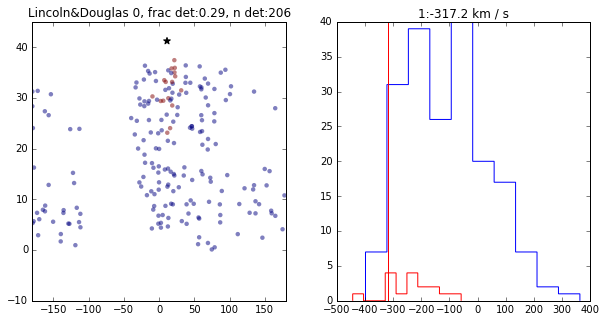

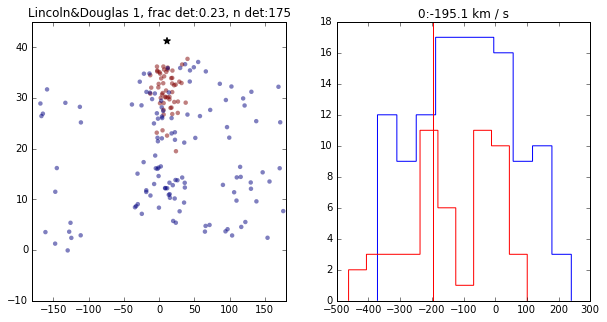

In [12]:
for name, tab in elvii_pairs.items():
    for i in (0, 1):
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        sens = tab['closest_sens{}'.format(i)]
        det = tab['detectable{}'.format(i)]
        
        fracdet = np.sum(det)/np.sum(np.isfinite(sens))
        
        
        otheridx = 1 if i==0 else 0
        x, y, z = tab['X'], tab['Y'], tab['Z']
        dother = ((x-x[otheridx])**2+(y-y[otheridx])**2+(z-z[otheridx])**2)**0.5
        inrvir = dother < tab['Rvir'][otheridx]
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1,2, 1)
        plt.scatter(ra[det].wrap_at(180*u.deg).deg, dec[det].deg, c=inrvir[det],lw=0, alpha=.5)
        plt.scatter(ra[otheridx].wrap_at(180*u.deg).deg, dec[otheridx].deg, color='k', alpha=1, marker='*', s=50)
        plt.title('{} {}, frac det:{:.2}, n det:{}'.format(name, i, fracdet, np.sum(det)))
        plt.xlim(-180, 180)
        plt.ylim(-10, 45)
        
        plt.subplot(1,2, 2)
        vr = tab['host{}_vrlsr'.format(i)]
        plt.hist(vr[det&~inrvir].value, color='b', histtype='step')
        plt.hist(vr[det&inrvir].value, color='r', histtype='step')
        plt.axvline(vr[otheridx].value, c='r')
        plt.title('{}:{:.4}'.format(otheridx, vr[otheridx]))

### On-sky maps of detectable/non-detectable 

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


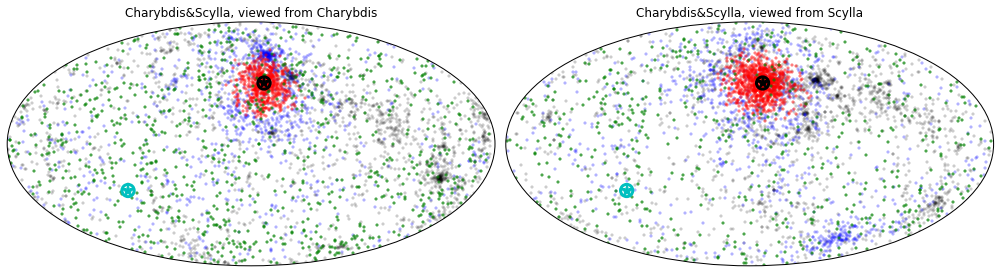

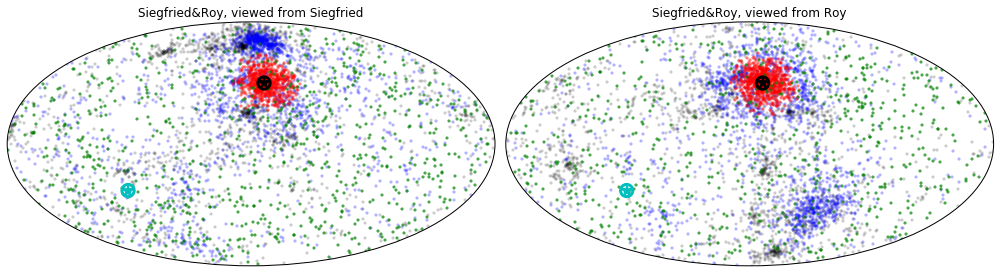

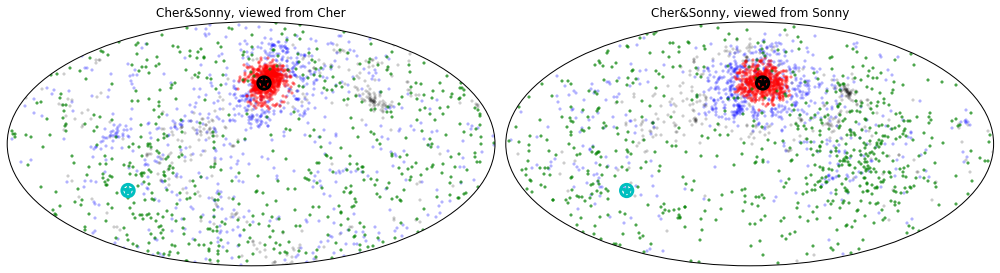

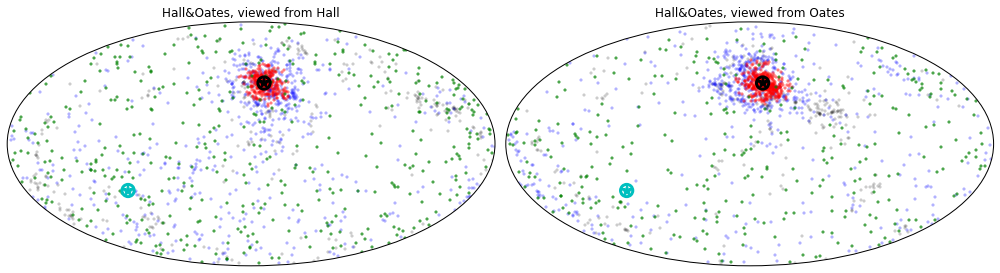

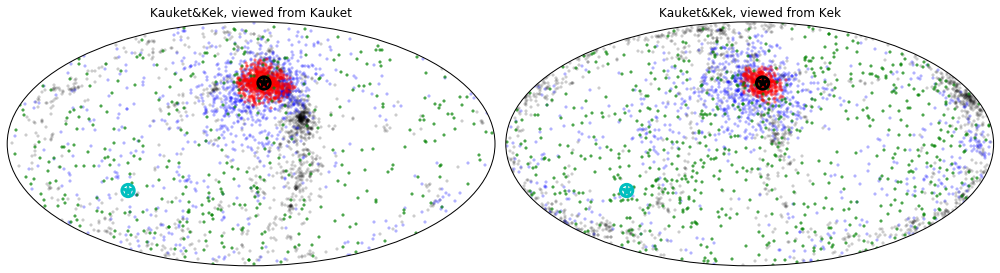

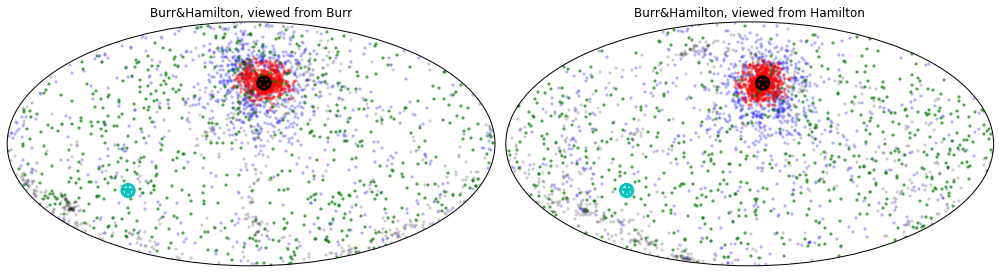

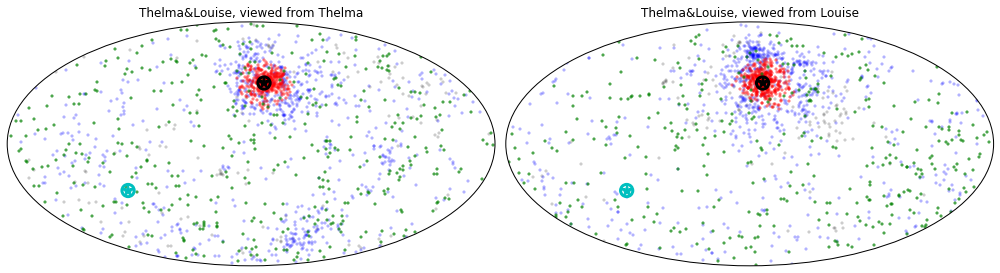

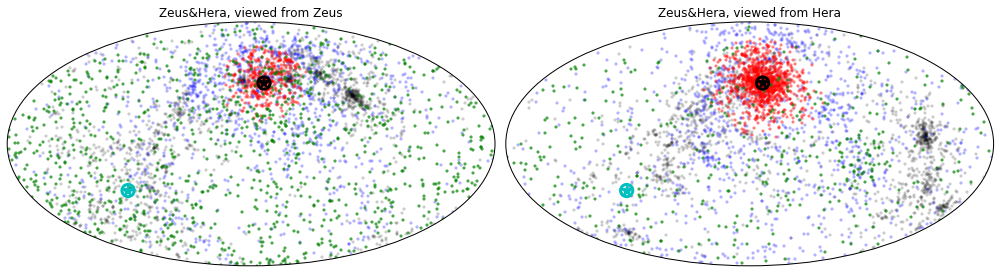

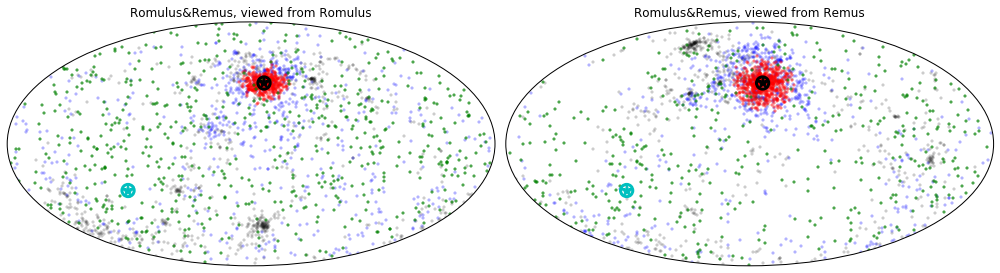

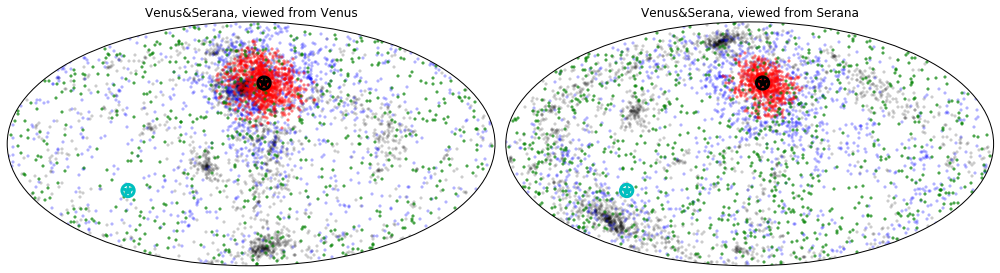

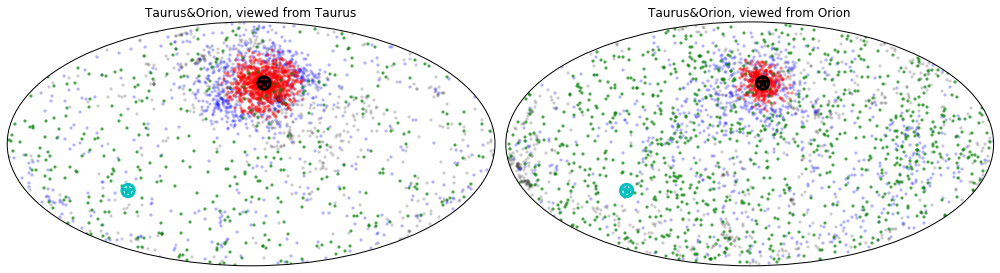

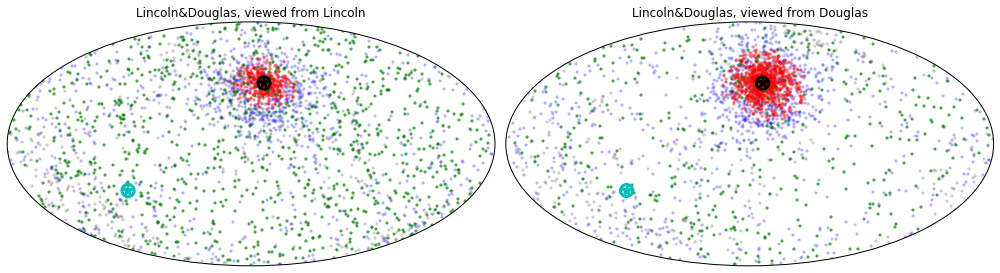

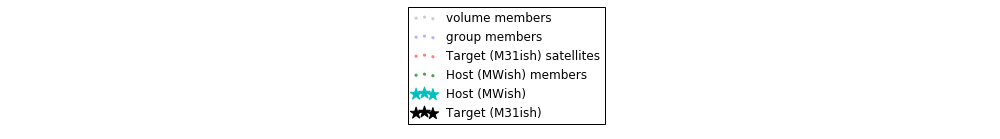

In [106]:
for names, tab in elvii_pairs.items():
    hnames = names.split('&')
    
    plt.figure(figsize=(14,10))
    for i in (0, 1):
        otheri = 1 if i==0 else 0
        
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        sens = tab['closest_sens{}'.format(i)]
        det = tab['detectable{}'.format(i)]

        scs = []
        scs.append(SkyCoord(tab['host0_lon'],tab['host0_lat'],distance=tab['host0_dist']))
        scs.append(SkyCoord(tab['host1_lon'],tab['host1_lat'],distance=tab['host1_dist']))
        nears = []
        nears.append(tab['host0_dist']<tab['Rvir'][0])
        nears.append(tab['host1_dist']<tab['Rvir'][1])
        nearboth = (tab['host0_dist']<.7*u.Mpc)|(tab['host1_dist']<.7*u.Mpc)

        ax = plt.subplot(1,2,i+1, projection='hammer')

        msk0 = ~(nears[i]|nears[otheri]|nearboth)
        msk2 = nears[otheri]
        msk3 = nears[i]
        msk1 = ~(msk0|msk2|msk3)

        ax.scatter(*coo_to_scatter_inputs(scs[i][msk0]), c='k',s=10, alpha=.2, lw=0, label='volume members')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk1]), c='b',s=10, alpha=.3, lw=0, label='group members')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk2]), c='r',s=10, alpha=.5, lw=0, label='Target (M31ish) satellites')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk3]), c='g',s=10, alpha=.7, lw=0, label='Host (MWish) members')

        ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150, label='Host (MWish)')
        ax.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150, label='Target (M31ish)')


        ax.scatter(*coo_to_scatter_inputs(scs[i][i]), edgecolors='c', marker='o', s=150, lw=3, c='none')
        ax.scatter(*coo_to_scatter_inputs(scs[i][otheri]), edgecolors='k', marker='o', s=150, lw=3, c='none')

        plt.xticks([])
        plt.yticks([])
        plt.title('{}, viewed from {}'.format(names, hnames[i]))
        plt.tight_layout()
        
        leghand, leglabels = ax.get_legend_handles_labels()

lfig = plt.figure(figsize=(14,2))
lax = plt.subplot()
lax.axis('off')
leg = plt.legend(leghand, leglabels,loc='center')
plt.tight_layout()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


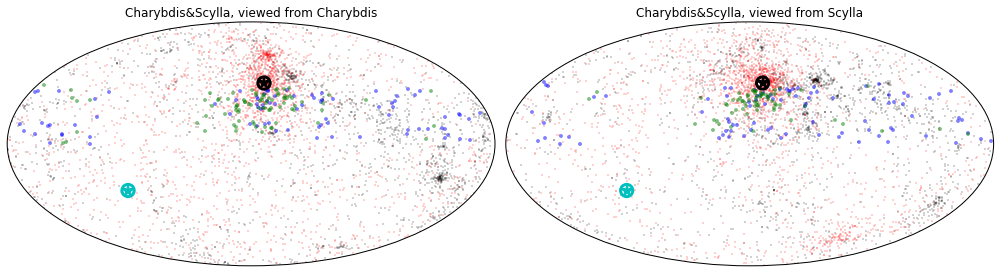

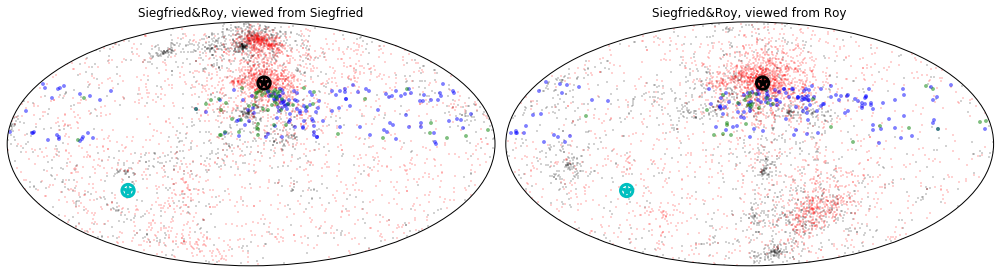

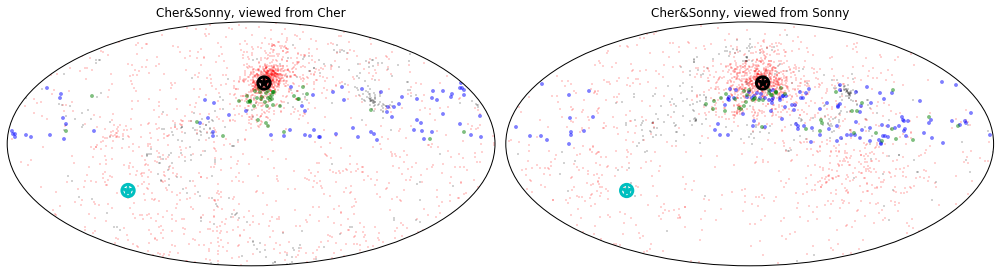

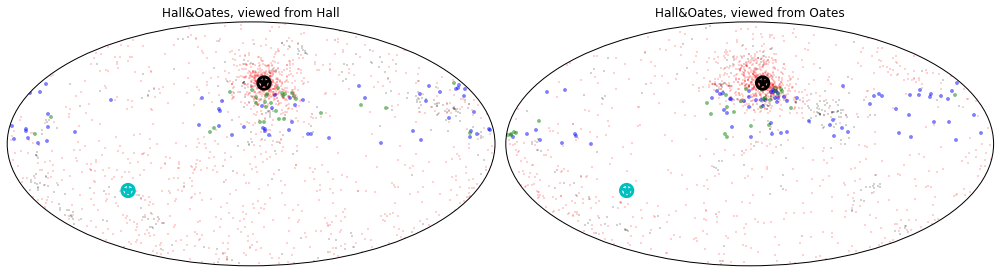

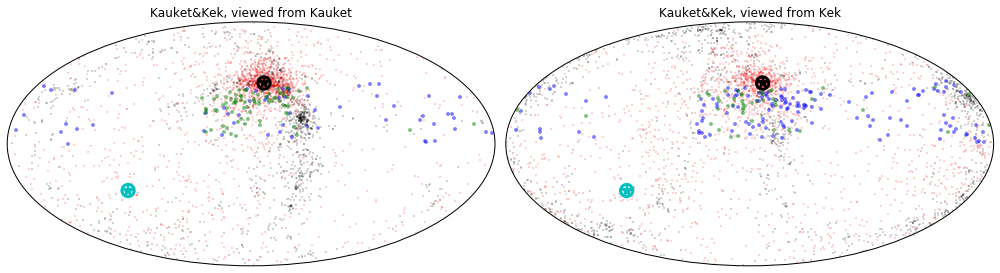

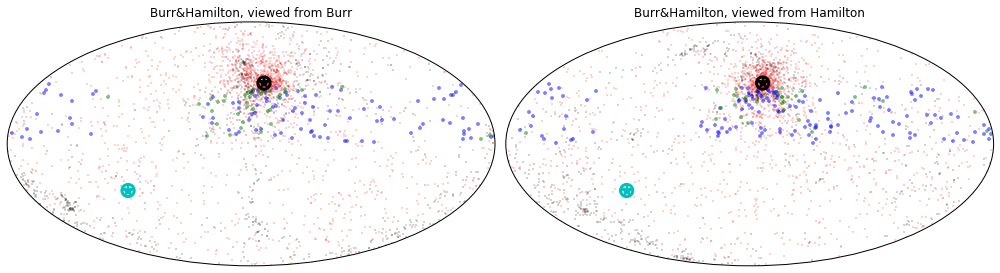

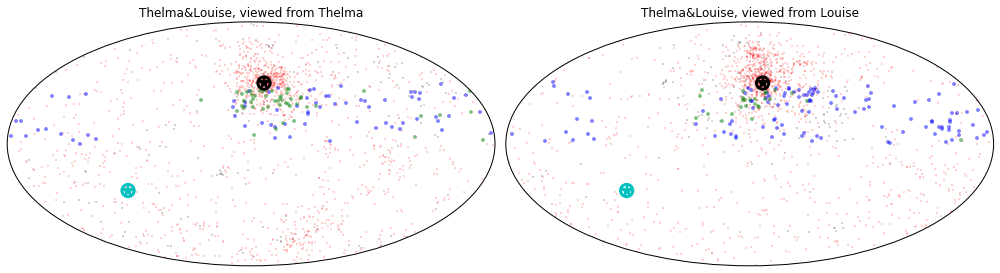

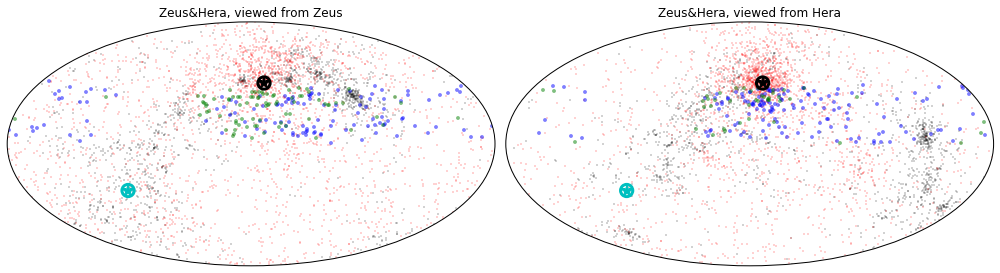

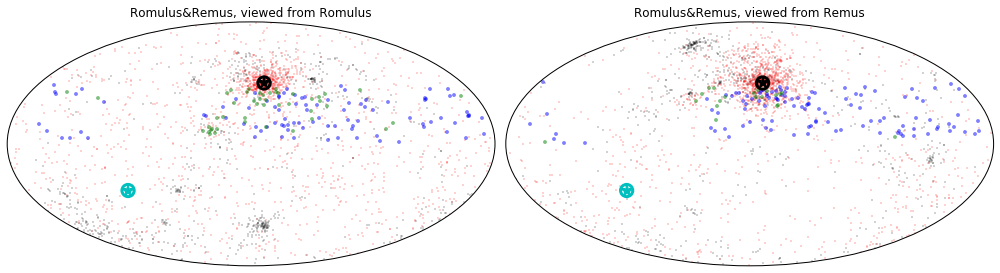

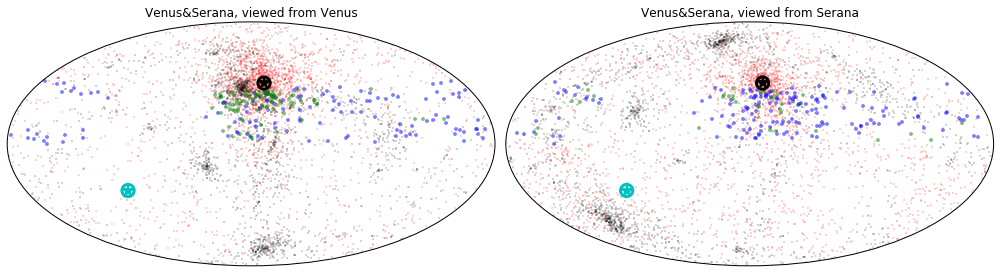

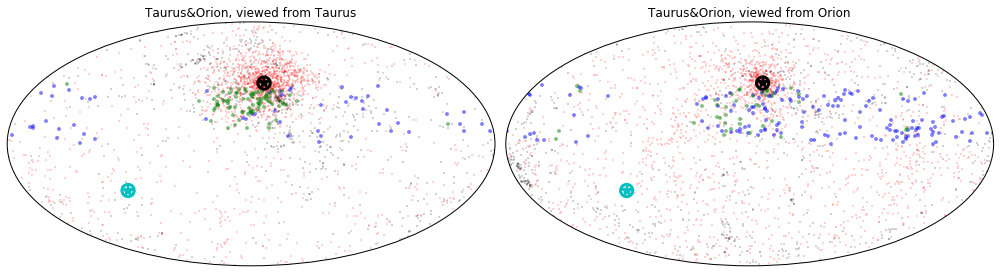

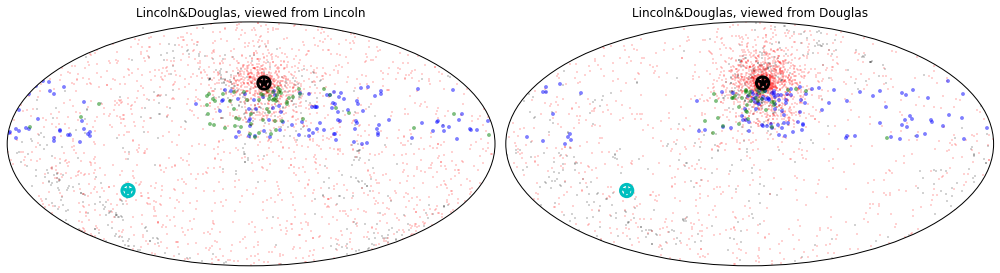

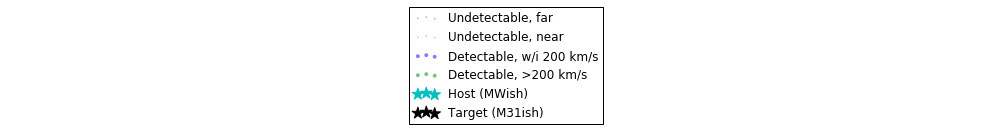

In [110]:
#this is different in that it is cut based on LSR velocities and detectability

for names, tab in elvii_pairs.items():
    hnames = names.split('&')
    
    plt.figure(figsize=(14,10))
    for i in (0, 1):
        otheri = 1 if i==0 else 0
        
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        
        sens = tab['closest_sens{}'.format(i)]
        det = tab['detectable{}'.format(i)]
        vlsr = tab['host{}_vrlsr'.format(i)]

        scs = []
        scs.append(SkyCoord(tab['host0_lon'],tab['host0_lat'],distance=tab['host0_dist']))
        scs.append(SkyCoord(tab['host1_lon'],tab['host1_lat'],distance=tab['host1_dist']))
        nears = []
        nears.append(tab['host0_dist']<tab['Rvir'][0])
        nears.append(tab['host1_dist']<tab['Rvir'][1])
        nearboth = (tab['host0_dist']<.7*u.Mpc)|(tab['host1_dist']<.7*u.Mpc)

        ax = plt.subplot(1,2,i+1, projection='hammer')
        
        msk0 = ~det&~nearboth
        msk1 = ~det&nearboth
        msk2 = det&(np.abs(vlsr)<200*u.km/u.s)&nearboth
        msk3 = det&(np.abs(vlsr)>200*u.km/u.s)&nearboth
        
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk0]), c='k',s=3, alpha=.3, lw=0, label='Undetectable, far')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk1]), c='r',s=3, alpha=.3, lw=0, label='Undetectable, near')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk2]), c='b',s=15, alpha=.5, lw=0, label='Detectable, w/i 200 km/s')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk3]), c='g',s=15, alpha=.5, lw=0, label='Detectable, >200 km/s')

        ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150, label='Host (MWish)')
        ax.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150, label='Target (M31ish)')


        ax.scatter(*coo_to_scatter_inputs(scs[i][i]), edgecolors='c', marker='o', s=150, lw=3, c='none')
        ax.scatter(*coo_to_scatter_inputs(scs[i][otheri]), edgecolors='k', marker='o', s=150, lw=3, c='none')

        plt.xticks([])
        plt.yticks([])
        plt.title('{}, viewed from {}'.format(names, hnames[i]))
        plt.tight_layout()
        
        leghand, leglabels = ax.get_legend_handles_labels()

lfig = plt.figure(figsize=(14,2))
lax = plt.subplot()
lax.axis('off')
leg = plt.legend(leghand, leglabels,loc='center')
plt.tight_layout()

### Relative velocities of the host halos

In [13]:
for name, tab in elvii_pairs.items():
    dx = tab['X'][1] - tab['X'][0]
    dy = tab['Y'][1] - tab['Y'][0]
    dz = tab['Z'][1] - tab['Z'][0]
    d = (dx**2 + dy**2 + dz**2)**0.5
    
    dvx = tab['Vx'][1] - tab['Vx'][0]
    dvy = tab['Vy'][1] - tab['Vy'][0]
    dvz = tab['Vz'][1] - tab['Vz'][0]
    vsep = (dvx*dx + dvy*dy + dvz*dz)/d
    
    print(name , '{:.4}'.format(d.to(u.kpc)), '{:.4}'.format(vsep.to(u.km/u.s)))

Charybdis&Scylla 705.1 kpc -71.16 km / s
Siegfried&Roy 877.6 kpc -130.8 km / s
Cher&Sonny 966.2 kpc -173.5 km / s
Hall&Oates 979.5 kpc -78.48 km / s
Kauket&Kek 1.04e+03 kpc -106.1 km / s
Burr&Hamilton 941.3 kpc -84.83 km / s
Thelma&Louise 832.2 kpc -111.5 km / s
Zeus&Hera 595.2 kpc -200.7 km / s
Romulus&Remus 935.4 kpc -86.78 km / s
Venus&Serana 687.4 kpc -157.8 km / s
Taurus&Orion 829.3 kpc -128.7 km / s
Lincoln&Douglas 780.4 kpc -142.0 km / s


### 3D plots for a selected host

In [184]:
# for interactive 3D plot
%matplotlib nbagg

In [185]:
hostname = 'Roy'

dobreak = False
for tname, tab in elvii_pairs.items():
    names = tname.split('&')
    for i, name in enumerate(names):
        if name==hostname:
            #tab already set
            othername = names[0] if i else names[1]
            hostidx = i
            otheridx = 1 if i==0 else 0
            dobreak = True
    if dobreak:
        break
else:
    del tab, hostidx
    raise ValueError('Could not find host ' + hostname)
    
axlims = [(-1.5, 1.5)]*3

<IPython.core.display.Javascript object>


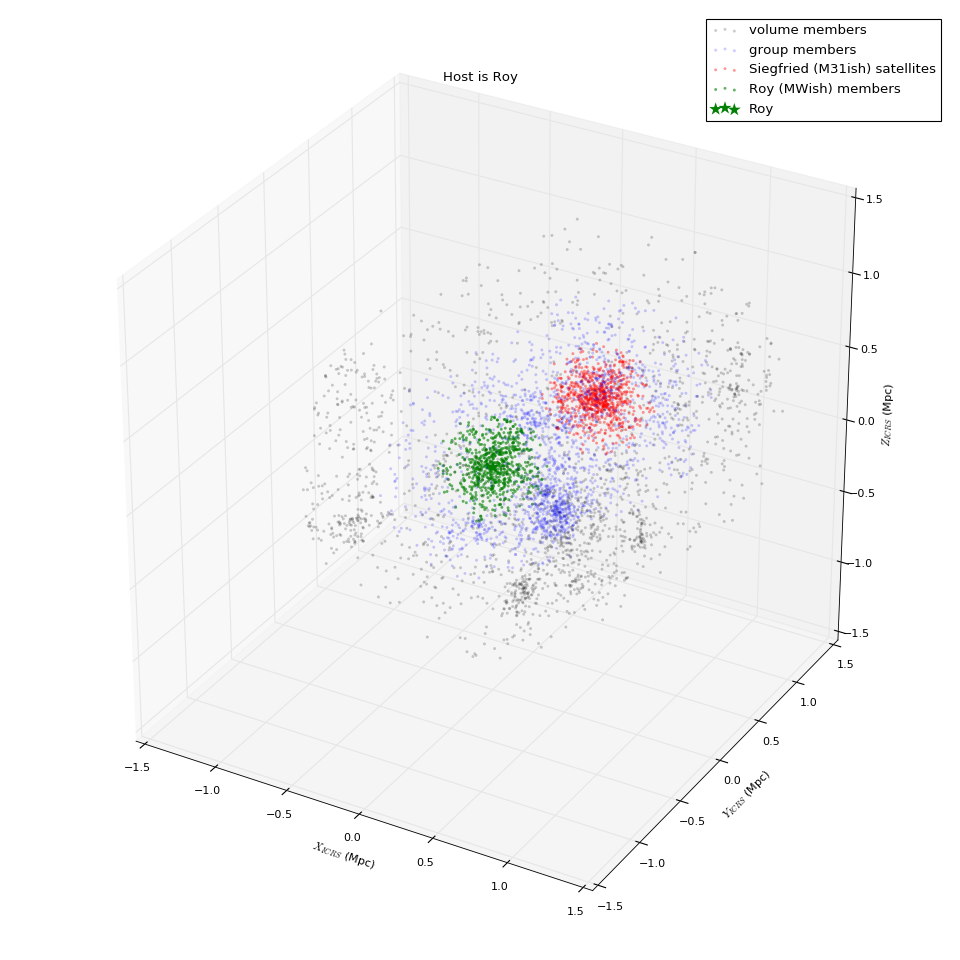

In [186]:
hoststr = 'host' + str(hostidx)
sc = SkyCoord(tab[hoststr+'_lon'],tab[hoststr+'_lat'],distance=tab[hoststr+'_dist'])
dx, dy, dz = sc.cartesian.xyz.to(u.Mpc).value
# dx = tab['X']-tab['X'][hostidx]
# dy = tab['Y']-tab['Y'][hostidx]
# dz = tab['Z']-tab['Z'][hostidx]

nears = []
nears.append(tab['host0_dist']<tab['Rvir'][0])
nears.append(tab['host1_dist']<tab['Rvir'][1])
nearboth = (tab['host0_dist']<.7*u.Mpc)|(tab['host1_dist']<.7*u.Mpc)


plt.figure(figsize=(12, 12))
ax = plt.subplot(projection='3d')

msk0 = ~(nears[hostidx]|nears[otheridx]|nearboth)
msk2 = nears[otheridx]
msk3 = nears[hostidx]
msk1 = ~(msk0|msk2|msk3)

ax.scatter3D(dx[msk0], dy[msk0], dz[msk0], c='k',s=7, alpha=.2, lw=0, label='volume members')
ax.scatter3D(dx[msk1], dy[msk1], dz[msk1], c='b',s=7, alpha=.2, lw=0, label='group members')
ax.scatter3D(dx[msk2], dy[msk2], dz[msk2], c='r',s=7, alpha=.4, lw=0, label=othername + ' (M31ish) satellites')
ax.scatter3D(dx[msk3], dy[msk3], dz[msk3], c='g',s=7, alpha=.6, lw=0, label=hostname + ' (MWish) members')
ax.scatter3D([0], [0], [0], c='g', marker='*', s=150, label=hostname, lw=0)
plt.legend(loc=0)


ax.set_xlim3d(*axlims[0])
ax.set_ylim3d(*axlims[1])
ax.set_zlim3d(*axlims[2])
ax.set_xlabel('$X_{ICRS}$ (Mpc)')
ax.set_ylabel('$Y_{ICRS}$ (Mpc)')
ax.set_zlabel('$Z_{ICRS}$ (Mpc)')

plt.title('Host is '+hostname)
plt.tight_layout()

<IPython.core.display.Javascript object>


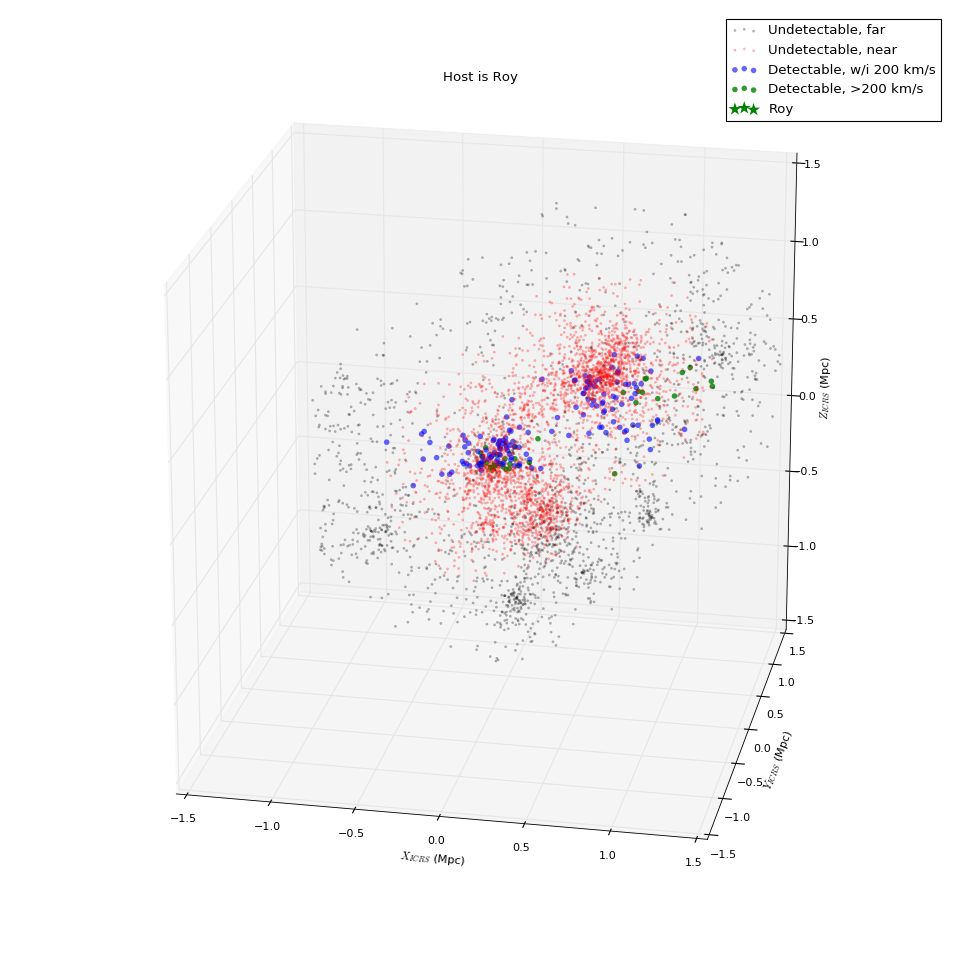

In [183]:
hoststr = 'host' + str(hostidx)
sc = SkyCoord(tab[hoststr+'_lon'],tab[hoststr+'_lat'],distance=tab[hoststr+'_dist'])
dx, dy, dz = sc.cartesian.xyz.to(u.Mpc).value
# dx = tab['X']-tab['X'][hostidx]
# dy = tab['Y']-tab['Y'][hostidx]
# dz = tab['Z']-tab['Z'][hostidx]

det = tab['detectable{}'.format(hostidx)]
vlsr = tab['host{}_vrlsr'.format(hostidx)]
nearboth = (tab['host0_dist']<.7*u.Mpc)|(tab['host1_dist']<.7*u.Mpc)

plt.figure(figsize=(12, 12))
ax = plt.subplot(projection='3d')

msk0 = ~det&~nearboth
msk1 = ~det&nearboth
msk2 = det&(np.abs(vlsr)<200*u.km/u.s)&nearboth
msk3 = det&(np.abs(vlsr)>200*u.km/u.s)&nearboth

ax.scatter3D(dx[msk0], dy[msk0], dz[msk0], c='k',s=6, alpha=.3, lw=0, label='Undetectable, far')
ax.scatter3D(dx[msk1], dy[msk1], dz[msk1], c='r',s=6, alpha=.3, lw=0, label='Undetectable, near')
ax.scatter3D(dx[msk2], dy[msk2], dz[msk2], c='b',s=25, alpha=.6, lw=0, label='Detectable, w/i 200 km/s')
ax.scatter3D(dx[msk3], dy[msk3], dz[msk3], c='g',s=25, alpha=.8, lw=0, label='Detectable, >200 km/s')
ax.scatter3D([0], [0], [0], c='g', marker='*', s=150, label=hostname, lw=0)
plt.legend(loc=0)

ax.set_xlim3d(*axlims[0])
ax.set_ylim3d(*axlims[1])
ax.set_zlim3d(*axlims[2])
ax.set_xlabel('$X_{ICRS}$ (Mpc)')
ax.set_ylabel('$Y_{ICRS}$ (Mpc)')
ax.set_zlabel('$Z_{ICRS}$ (Mpc)')

plt.title('Host is '+hostname)
plt.tight_layout()

In [187]:
%matplotlib inline

# Tests of LSR effects and roll-importance

In [14]:
def coo_to_scatter_inputs(coo):
    x = coo.spherical.lon.wrap_at(180*u.deg).rad
    y = coo.spherical.lat.rad
    return np.atleast_1d(x), np.atleast_1d(y)

# Check what roll looks like for a single pair

In [16]:
nroll = 10

newtabs = OrderedDict()
for tab in elvii_pairs.values():
    for roll in np.linspace(0, 360, nroll, False)*u.deg:
        newtabs[roll] = newtab = tab.copy()
        data_loaders.add_oriented_radecs(newtab, 0, 1, target_coord=m31, roll_angle=roll)
        data_loaders.add_oriented_radecs(newtab, 1, 0, target_coord=m31, roll_angle=roll)
    break

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


In [17]:
sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])

#these should all be the same for the assumptions to hold right
data_loaders.galactic_center.separation(m31), sc0[0].separation(sc0[1]), sc1[0].separation(sc1[1])

(<Angle 118.77568035668436 deg>,
 <Angle 118.77568035668436 deg>,
 <Angle 118.7756803566844 deg>)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


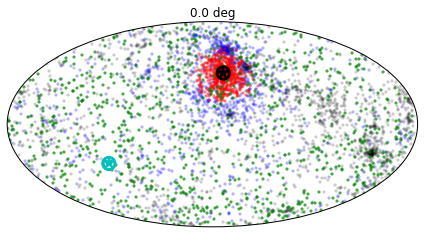

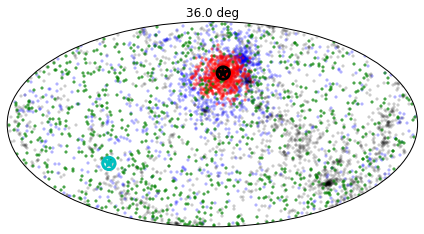

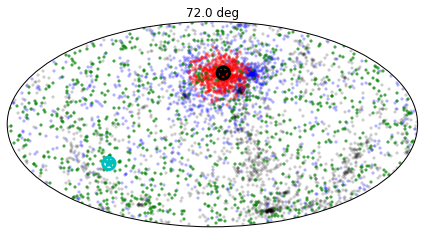

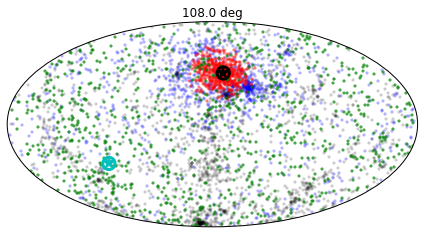

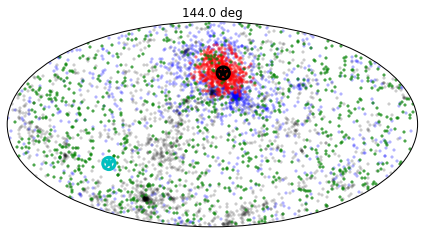

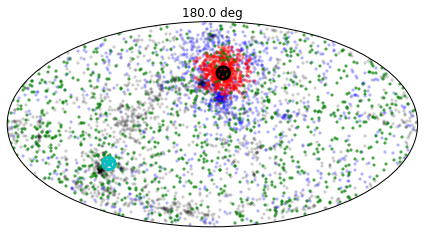

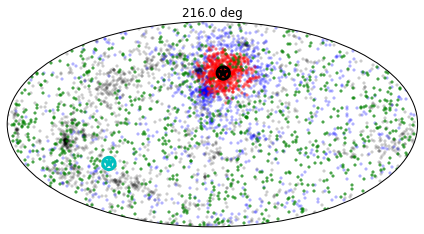

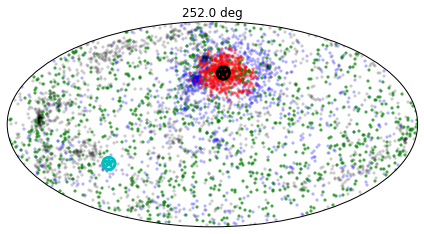

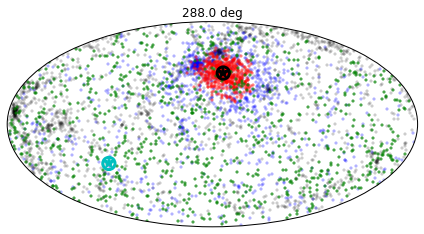

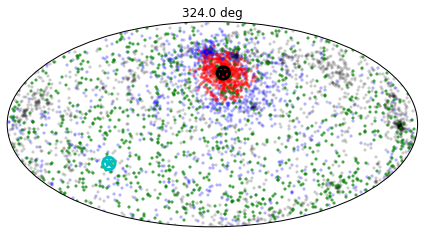

In [18]:
for roll, newtab in newtabs.items():
    sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
    sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])
    near1 = newtab['host1_dist']<newtab['Rvir'][1]
    near0 = newtab['host0_dist']<newtab['Rvir'][0]
    nearish = (newtab['host0_dist']<.7*u.Mpc)|(newtab['host1_dist']<.7*u.Mpc)

    plt.figure()
    plt.subplot(projection='hammer')
    
    msk0 = ~(near1|near0|nearish)
    msk2 = near1
    msk3 = near0
    msk1 = ~(msk0|msk2|msk3)

    plt.scatter(*coo_to_scatter_inputs(sc0[msk0]), c='k',s=10, alpha=.2, lw=0)
    plt.scatter(*coo_to_scatter_inputs(sc0[msk1]), c='b',s=10, alpha=.3, lw=0)
    plt.scatter(*coo_to_scatter_inputs(sc0[msk2]), c='r',s=10, alpha=.5, lw=0)
    plt.scatter(*coo_to_scatter_inputs(sc0[msk3]), c='g',s=10, alpha=.7, lw=0)

    plt.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150)
    plt.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150)


    plt.scatter(*coo_to_scatter_inputs(sc0[0]), edgecolors='c', marker='o', s=150, lw=3, c='none')
    plt.scatter(*coo_to_scatter_inputs(sc0[1]), edgecolors='k', marker='o', s=150, lw=3, c='none')

    plt.xticks([])
    plt.yticks([])
    plt.title(str(roll))
    plt.tight_layout()

 ## Look at gal_vsr velocities

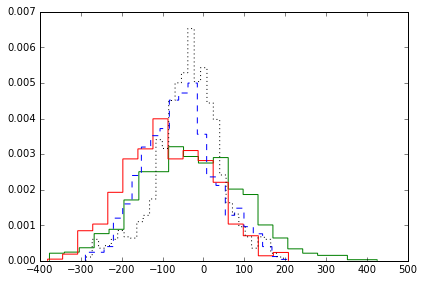

In [23]:
bins='freedman'
ahist(newtab['host0_galvr'][near0], histtype='step', bins=bins, color='g', normed=True)
ahist(newtab['host0_galvr'][near1], histtype='step', bins=bins, color='r', normed=True)
ahist(newtab['host0_galvr'][nearish&~(near0|near1)], histtype='step', bins=bins, color='b', normed=True, ls='--')
ahist(newtab['host0_galvr'][~(near1|near0|nearish)], histtype='step', bins=bins, color='k', normed=True, ls=':')
plt.tight_layout()

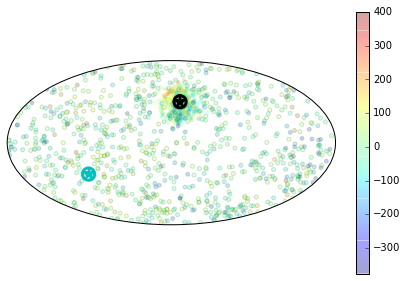

In [24]:
newtab = newtabs[0*u.deg]

sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])
near1 = newtab['host1_dist']<newtab['Rvir'][1]
near0 = newtab['host0_dist']<newtab['Rvir'][0]
nearish = (newtab['host0_dist']<.7*u.Mpc)|(newtab['host1_dist']<.7*u.Mpc)

plt.figure()
plt.subplot(projection='hammer')

plt.scatter(*coo_to_scatter_inputs(sc0[near1]), c=newtab['host0_galvr'][near1], s=15, alpha=.2, lw=1, edgecolor='')
plt.scatter(*coo_to_scatter_inputs(sc0[near0]), c=newtab['host0_galvr'][near0], s=15, alpha=.2, lw=1, edgecolor='g')
plt.colorbar()

plt.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150)
plt.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150)


plt.scatter(*coo_to_scatter_inputs(sc0[0]), edgecolors='c', marker='o', s=150, lw=3, c='none')
plt.scatter(*coo_to_scatter_inputs(sc0[1]), edgecolors='k', marker='o', s=150, lw=3, c='none')

plt.xticks([])
plt.yticks([])
plt.tight_layout()

 ## And vrlsr

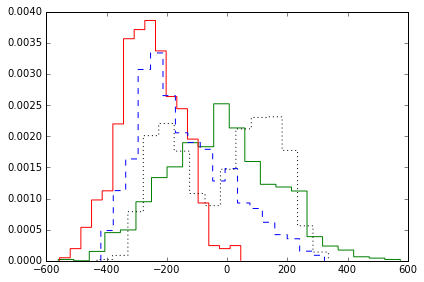

In [25]:
bins='freedman'
ahist(newtab['host0_vrlsr'][near0], histtype='step', bins=bins, color='g', normed=True)
ahist(newtab['host0_vrlsr'][near1], histtype='step', bins=bins, color='r', normed=True)
ahist(newtab['host0_vrlsr'][nearish&~(near0|near1)], histtype='step', bins=bins, color='b', normed=True, ls='--')
ahist(newtab['host0_vrlsr'][~(near1|near0|nearish)], histtype='step', bins=bins, color='k', normed=True, ls=':')
plt.tight_layout()

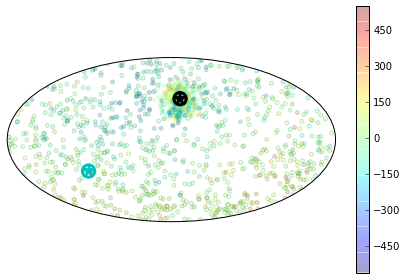

In [26]:
newtab = newtabs[0*u.deg]

sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])
near1 = newtab['host1_dist']<newtab['Rvir'][1]
near0 = newtab['host0_dist']<newtab['Rvir'][0]
nearish = (newtab['host0_dist']<.7*u.Mpc)|(newtab['host1_dist']<.7*u.Mpc)

plt.figure()
plt.subplot(projection='hammer')

plt.scatter(*coo_to_scatter_inputs(sc0[near1]), c=newtab['host0_vrlsr'][near1], s=15, alpha=.2, lw=1, edgecolor='')
plt.scatter(*coo_to_scatter_inputs(sc0[near0]), c=newtab['host0_vrlsr'][near0], s=15, alpha=.2, lw=1, edgecolor='g')
plt.colorbar()

plt.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150)
plt.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150)


plt.scatter(*coo_to_scatter_inputs(sc0[0]), edgecolors='c', marker='o', s=150, lw=3, c='none')
plt.scatter(*coo_to_scatter_inputs(sc0[1]), edgecolors='k', marker='o', s=150, lw=3, c='none')

plt.xticks([])
plt.yticks([])
plt.tight_layout()

## Map out where Everything is is in the LSR frame 

In [27]:
n = 1000
lat = np.arcsin(2*np.random.rand(n)-1)*u.radian
lon  = np.random.rand(n)*360*u.deg

usr = UnitSphericalRepresentation(lat=lat, lon=lon)
cart = usr.to_cartesian()

In [28]:
#  map out a grid on the sphere
ntopring = 4
nlats = 21

ringlats = np.linspace(-90, 90, nlats+2)[1:-1]*u.deg
eqnum = ntopring/np.cos(ringlats[0])

lats = []
lons = []
for l in ringlats.to(u.deg):
    n = int(np.round(eqnum*np.cos(l)))
    lons.extend(np.linspace(0, 360, n, False))
    lats.extend([l.value]*n)
    
    
# velocities in the LSR converted to a galactic-fixed frame
vrot = 220*u.km/u.s

sc = SkyCoord(l=lons*u.deg, b=lats*u.deg, frame='galactic')
vr = -sc.cartesian.y*vrot

lsrrotdir = SkyCoord(l=90*u.deg, b=0*u.deg, frame='galactic')
lsrantirotdir = SkyCoord(l=270*u.deg, b=0*u.deg, frame='galactic')

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


([], <a list of 0 Text xticklabel objects>)

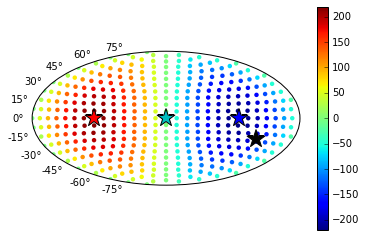

In [29]:
ax = plt.subplot(projection='hammer')
scat = ax.scatter(*coo_to_scatter_inputs(sc), c=vr, lw=0)
plt.colorbar(scat)

ax.scatter(*coo_to_scatter_inputs(m31.galactic), c='k', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.galactic), c='c', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(lsrrotdir.galactic), c='b', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(lsrantirotdir.galactic), c='r', marker='*', s=350)

plt.xticks([])

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


([], <a list of 0 Text xticklabel objects>)

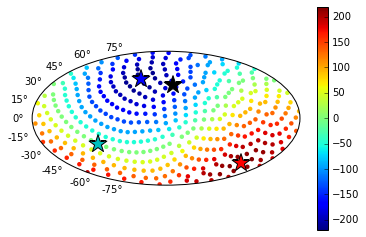

In [30]:
ax = plt.subplot(projection='hammer')
scat = ax.scatter(*coo_to_scatter_inputs(sc.icrs), c=vr, lw=0)
plt.colorbar(scat)

ax.scatter(*coo_to_scatter_inputs(m31.icrs), c='k', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), c='c', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(lsrrotdir.icrs), c='b', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(lsrantirotdir.icrs), c='r', marker='*', s=350)

plt.xticks([])